In [12]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=True)
numSamples = len(train_dataset)                          

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


In [ ]:
# Prepare data tensors 
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

# Prepare dataset
X_raw = _get_tensor(train_dataset, numSamples) 
dim = X_raw[0].numel()  # 28*28 = 784
r = 25  # bottleneck / testing rank

# X Stuff
X = X_raw.view(numSamples, -1).T
mu_X = X.mean(dim=1, keepdim=True)  
X_centered = X - mu_X  
covX = 1 / (numSamples - 1) * (X_centered @ X_centered.T) + 1e-5 * torch.eye(dim, device=device)
K_X = torch.linalg.cholesky(covX)


# E Stuff
noiseSigma = 0.05
E = torch.randn_like(X) * noiseSigma
gammaE = noiseSigma**2 * torch.eye(dim, device=device)
L_E = torch.linalg.cholesky(gammaE)

# Y Stuff
Y = X + E

# Theoretical Optimizer
zeroBlock = torch.zeros_like(K_X)
C = torch.cat([K_X, zeroBlock], dim=1)
U, S, Vh = torch.linalg.svd(C)
U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
D = torch.cat([K_X, L_E], dim=1)
M_r = U_r @ S_r @ Vh_r @ torch.linalg.pinv(D)

# Theoretical optimal bias vector
br = mu_X - M_r @ mu_X

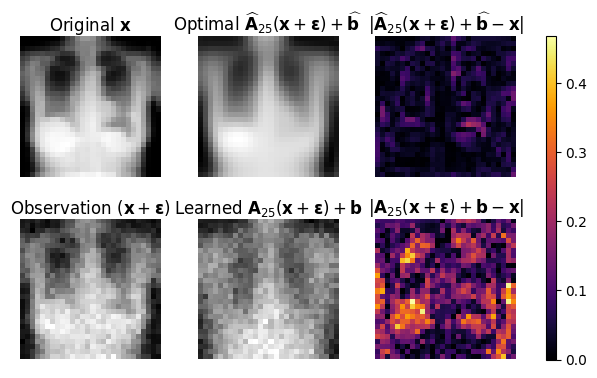

In [ ]:
# Autoencoder setup 
batch_size = 128
num_epochs = 200

X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=True)
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop using average per-sample L2 error 
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y.T)
    target  = X.T

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight
        b_learned = model.decoder.bias.view(-1, 1)  
        
        diffs = A_learned @ Y + b_learned - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()
        train_errors.append(avg_l2_err)


# Compact 2×3 gallery with Everforest colormap 
from matplotlib import gridspec


idx = 7181

orig_img   = X_raw[idx].view(28, 28).cpu()
y_img      = Y[:, idx].view(28, 28).cpu()
opt_img    = (M_r @ Y + br)[:, idx].view(28, 28).cpu()
learn_img  = (A_learned @ Y + b_learned)[:, idx].view(28, 28).detach().cpu()

err_opt   = torch.abs(opt_img   - orig_img)
err_learn = torch.abs(learn_img - orig_img)
err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

fig = plt.figure(figsize=(8, 4.2))
gs  = gridspec.GridSpec(
    2, 4,
    width_ratios=[1, 1, 1, 0.06],
    wspace=0.2, hspace=0.30
)

# row 0
ax = fig.add_subplot(gs[0, 0])
ax.imshow(orig_img, cmap='gray')
ax.set_title(r'Original $\mathbf{x}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 1])
ax.imshow(opt_img, cmap='gray')
ax.set_title(fr'Optimal $\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{al}}}} (\mathbf{{x}} + \mathbf{{\varepsilon}}) + \widehat{{\mathbf{{b}}}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[0, 2])
im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\widehat{{\mathbf{{A}}}}_{{{r}}}^{{\text{{al}}}} (\mathbf{{x}} + \mathbf{{\varepsilon}}) + \widehat{{\mathbf{{b}}}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# row 1
ax = fig.add_subplot(gs[1, 0])
ax.imshow(y_img, cmap='gray')
ax.set_title(r'Observation $(\mathbf{x} + \mathbf{\varepsilon})$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 1])
ax.imshow(learn_img, cmap='gray')
ax.set_title(fr'Learned $\mathbf{{A}}_{{{r}}}^{{\text{{al}}}} (\mathbf{{x}} + \mathbf{{\varepsilon}}) + \mathbf{{b}}$', pad=4)
ax.axis('off')

ax = fig.add_subplot(gs[1, 2])
ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
ax.set_title(fr'$|\mathbf{{A}}_{{{r}}}^{{\text{{al}}}} (\mathbf{{x}} + \mathbf{{\varepsilon}}) + \mathbf{{b}} - \mathbf{{x}}|$', pad=4)
ax.axis('off')

# color-bar
cax = fig.add_subplot(gs[:, 3])
plt.colorbar(im, cax=cax)
cax.yaxis.tick_right()

import os
out_dir = f"NoisyAffLin/MedMNIST/Pics"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f"{out_dir}/noisyAffLin_{data_flag}_mapping{idx}_errorcomparison.png", dpi=300)
plt.show()

In [15]:
import os, pickle, torch
from collections import defaultdict
from copy import deepcopy
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt



# where to stash matrices and final plots 
save_root     = "NoisyAffLin"
matrices_root = os.path.join(save_root, "MedMNIST", "Matrices")
tests_root    = os.path.join(save_root, "MedMNIST", "Tests")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# helper: run rank sweep on ONE MedMNIST subset 
def run_rank_sweep(data_flag, ranks, train_epochs=350, lr=1e-3):
    """Return ([theory avg l2], [AE avg l2]) for the given dataset
       and store matrices to pickles for every rank."""
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    train_ds = DataClass(split='train', download=True)

    numSamples = len(train_ds)
    X_raw = _get_tensor(train_ds, numSamples)
    dim = X_raw[0].numel()

    # X Stuff
    X = X_raw.view(numSamples, -1).T
    mu_X = X.mean(dim=1, keepdim=True)  
    X_centered = X - mu_X  
    covX = 1 / (numSamples - 1) * (X_centered @ X_centered.T) + 1e-5 * torch.eye(dim, device=device)
    K_X = torch.linalg.cholesky(covX)


    # E Stuff
    noiseSigma = 0.05
    E = torch.randn_like(X) * noiseSigma
    gammaE = noiseSigma**2 * torch.eye(dim, device=device)
    L_E = torch.linalg.cholesky(gammaE)

    # Y Stuff
    Y = X + E

    # Theoretical Optimizer
    zeroBlock = torch.zeros_like(K_X)
    C = torch.cat([K_X, zeroBlock], dim=1)
    U, S, Vh = torch.linalg.svd(C)
        
    theory_err, learned_err = [], []
    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")

        U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
        D = torch.cat([K_X, L_E], dim=1)
        M_r = U_r @ S_r @ Vh_r @ torch.linalg.pinv(D)

        # Theoretical optimal bias vector
        br = mu_X - M_r @ mu_X 
        
        diffs_opt = M_r @ Y + br - X
        avg_l2_opt = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        ae = LinearAutoencoder(dim, r).to(device)
        opt = optim.Adam(ae.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for _ in range(train_epochs):
            opt.zero_grad()
            out = ae(Y.T)
            loss = criterion(out, X.T)
            loss.backward()
            opt.step()

        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            b = ae.decoder.bias.detach().view(-1, 1).cpu()
            A = W_dec @ W_enc
            diffs_learn = A.to(device) @ Y + b.to(device) - X
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        with open(dump_path, "wb") as f:
            pickle.dump(
                {
                    "optimalMatrix":  M_r.cpu(),
                    "optimalBias":    br.cpu(),
                    "encoderWeight":  W_enc,
                    "decoderWeight":  W_dec,
                    "learnedBias":    b,
                    "avgL2Optimal":   avg_l2_opt,
                    "avgL2Learned":   avg_l2_learn,
                },
                f,
                protocol=pickle.HIGHEST_PROTOCOL,
            )

    return theory_err, learned_err

# run all requested datasets (original sizes of: 200k, 100k, 50k, 10k, 1k)
datasets  = ['tissuemnist', 'chestmnist', 'organamnist', 'retinamnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)
num_epochs = 200 # define here for training / plot naming

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=num_epochs)
    results[flag]['theory']  = th
    results[flag]['learned'] = le


▶ Running rank sweep for tissuemnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\tissuemnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for organamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for retinamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700


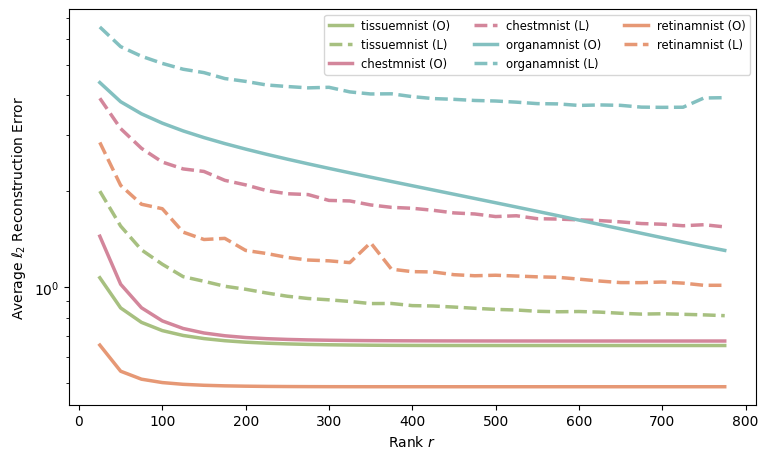

In [16]:
# pastel-Everforest colours
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 2.5, 4

# combined plot
plt.figure(figsize=(7.8, 4.7))
short_label = {'theory': 'O', 'learned': 'L'}

for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ('theory', 'learned'):
        plt.plot(ranks,
                 results[flag][kind],
                 line_styles[kind],
                 #marker=markers[kind],
                 color=col,
                 lw=lw,
                 ms=ms, 
                 label=f"{flag} ({short_label[kind]})")

plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
#plt.title('Average $\ell_2$ Error vs. Rank')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
plt.savefig("NoisyAffLin/MedMNIST/Pics/noisyAffLin_ranksweep_200ep.png")
plt.show()
